In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO

from PIL import Image

In [2]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [3]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [4]:
def plot_raw_shotchart(
        data_frame,
        title,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False,
        plot_image=False,
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    #data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    #df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    #df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    #df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    if plot_attempts:
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if df_by_zone_median.iloc[index].name not in text_location_mapping:
                continue
            x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
            if zone_shots_attempted < 1:
                continue
            ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    if plot_image:    
        team_id = made_shots.iloc[0].TEAM_ID
        player_id = made_shots.iloc[0].PLAYER_ID
        url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        ax.imshow(img, extent=(132, 252, -48, 40))
    
    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if plot_types:
        texts = []
        for index in range(len(data_frame)):
            item = data_frame.iloc[index]
            texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, color=bball_light_orange, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
                   bbox={'facecolor': bball_gray, 'alpha': 0.75, 'edgecolor': bball_light_orange}, zorder=0))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color=bball_white), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

### Luka Dončić

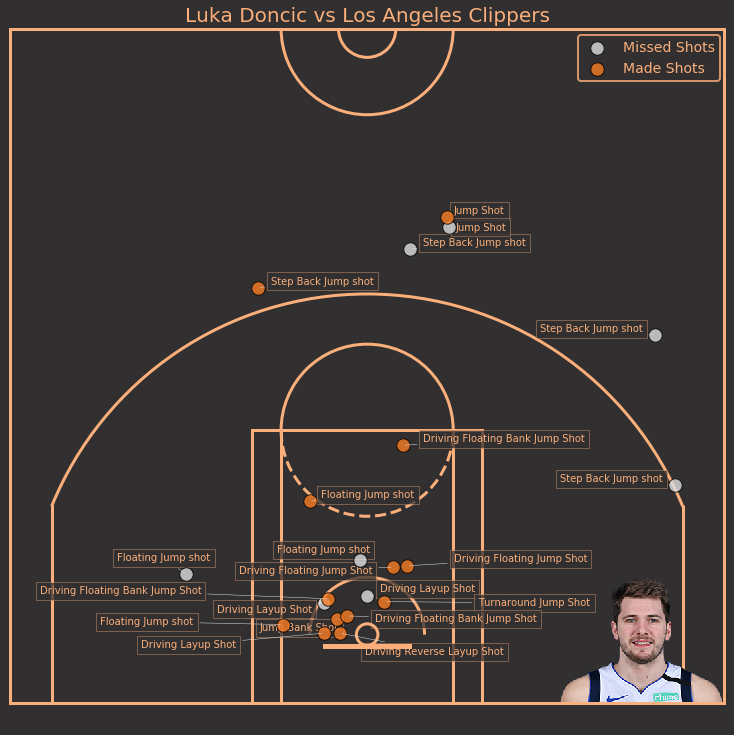

In [5]:
player_id = find_players_by_full_name("Luka Doncic")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Luka Doncic vs Los Angeles Clippers", plot_types=True, plot_image=True)

### Vucevic

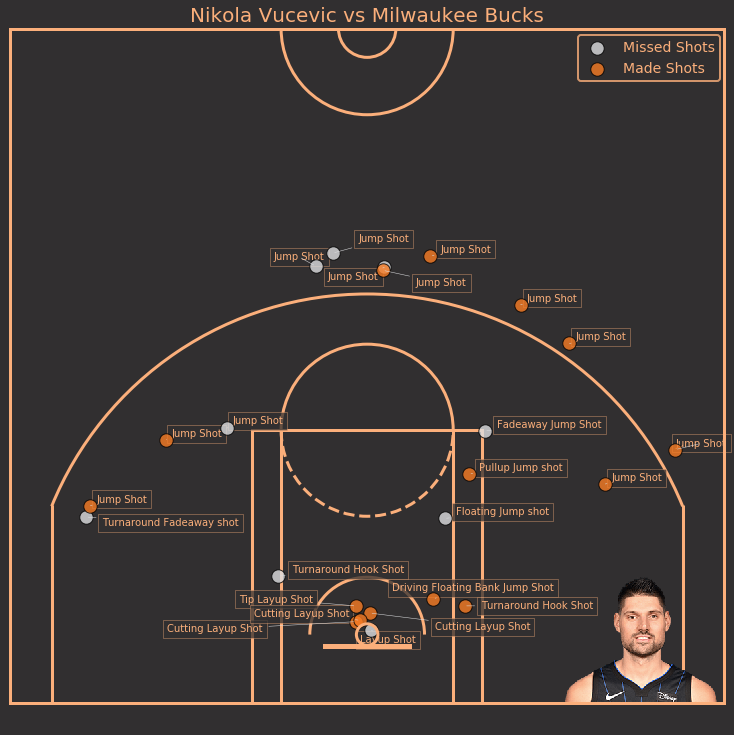

In [11]:
player_id = find_players_by_full_name("Nikola Vucevic")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Nikola Vucevic vs Milwaukee Bucks", plot_types=True, plot_image=True)

### AD

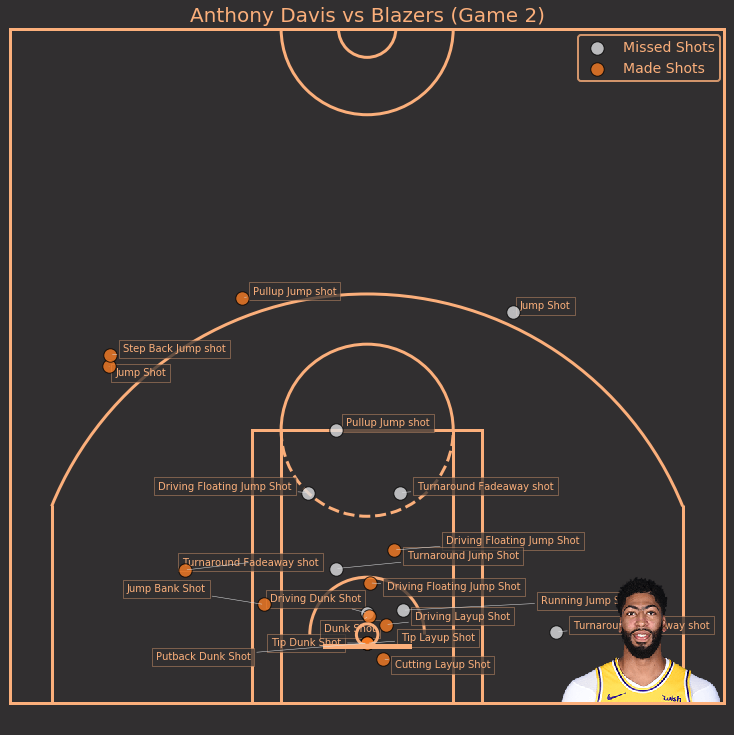

In [5]:
player_id = find_players_by_full_name("Anthony Davis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Anthony Davis vs Blazers (Game 2)", plot_types=True, plot_image=True)

### Kawhi Leonard

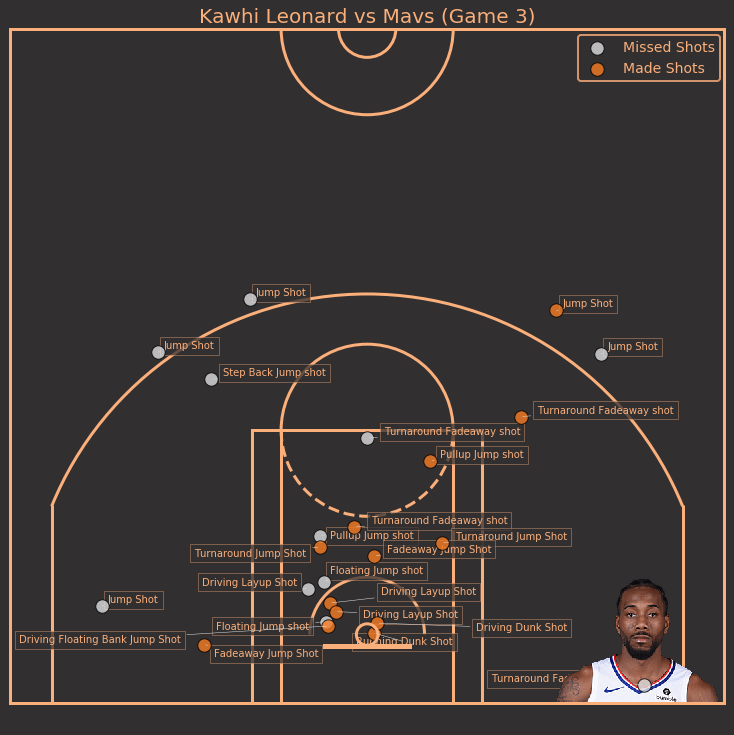

In [5]:
player_id = find_players_by_full_name("Kawhi Leonard")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Kawhi Leonard vs Mavs (Game 3)", plot_types=True, plot_image=True)

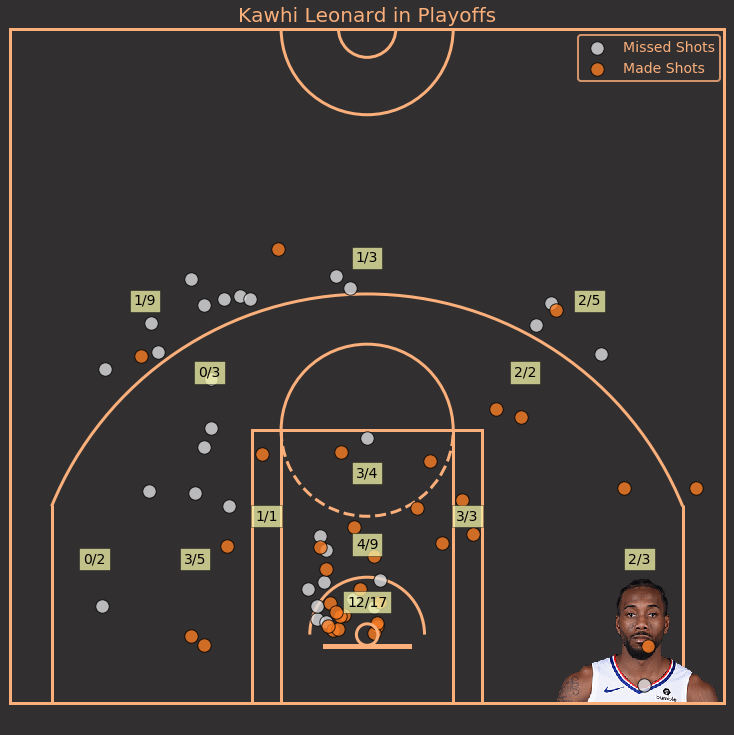

In [6]:
player_id = find_players_by_full_name("Kawhi Leonard")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

#player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Kawhi Leonard in Playoffs", plot_types=False, plot_attempts=True, plot_image=True)

### LeBron

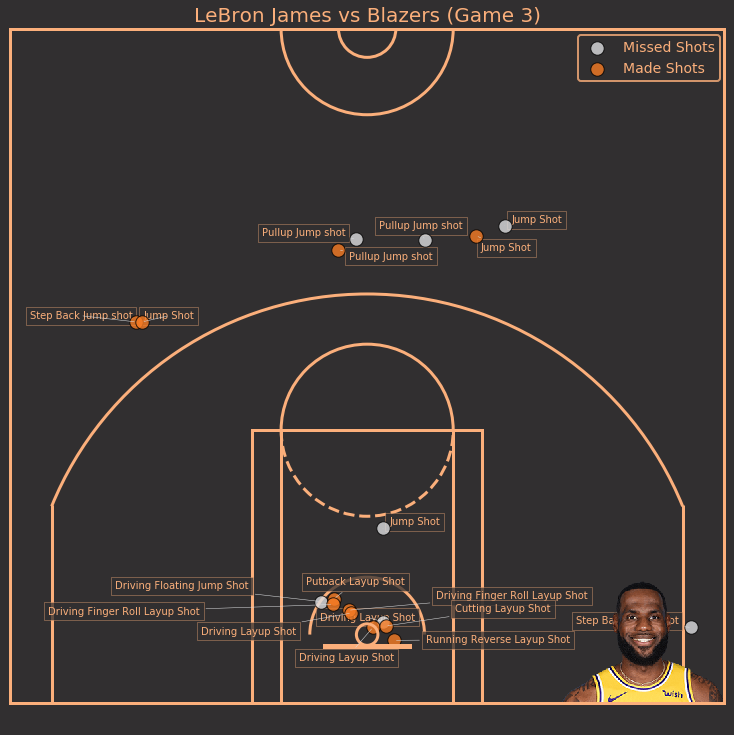

In [7]:
player_id = find_players_by_full_name("LeBron James")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="LeBron James vs Blazers (Game 3)", plot_types=True, plot_attempts=False, plot_image=True)

### Harden last two

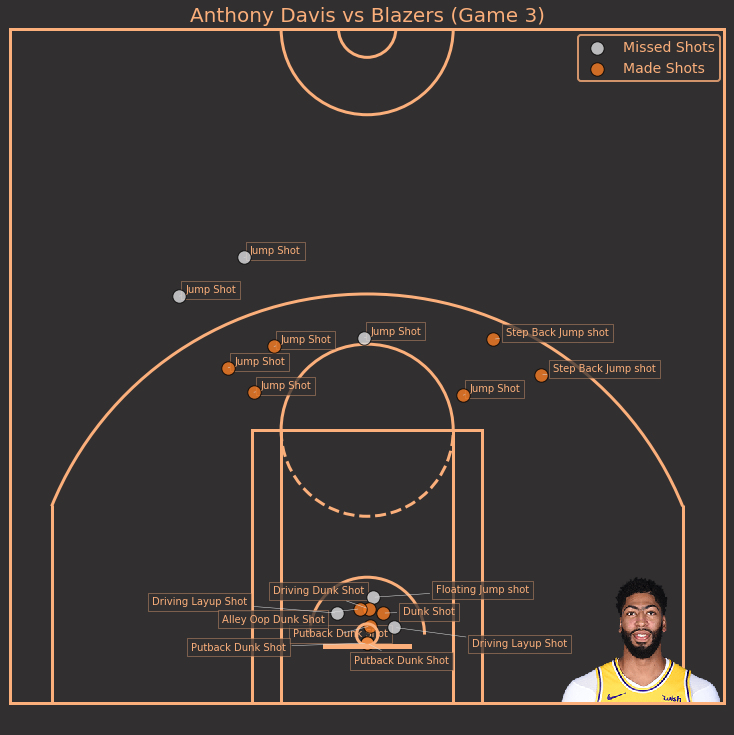

In [9]:
player_id = find_players_by_full_name("Anthony Davis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Anthony Davis vs Blazers (Game 3)", plot_types=True, plot_attempts=False, plot_image=True)

### Luka Dončić

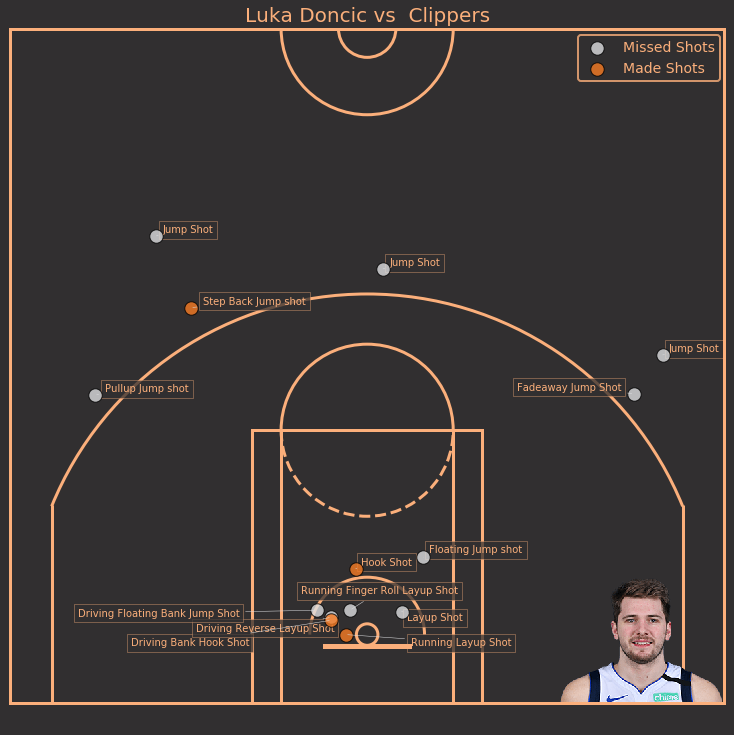

In [47]:
player_id = find_players_by_full_name("Luka Doncic")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Luka Doncic vs  Clippers", plot_types=True, plot_image=True)

In [51]:
player_df.iloc[0]

GRID_TYPE              Shot Chart Detail
GAME_ID                       0041900153
GAME_EVENT_ID                         15
PLAYER_ID                        1629029
PLAYER_NAME                  Luka Doncic
TEAM_ID                       1610612742
TEAM_NAME               Dallas Mavericks
PERIOD                                 1
MINUTES_REMAINING                     10
SECONDS_REMAINING                     43
EVENT_TYPE                   Missed Shot
ACTION_TYPE                   Layup Shot
SHOT_TYPE                 2PT Field Goal
SHOT_ZONE_BASIC          Restricted Area
SHOT_ZONE_AREA                 Center(C)
SHOT_ZONE_RANGE          Less Than 8 ft.
SHOT_DISTANCE                          2
LOC_X                                 24
LOC_Y                                 16
SHOT_ATTEMPTED_FLAG                    1
SHOT_MADE_FLAG                         0
GAME_DATE                       20200821
HTM                                  DAL
VTM                                  LAC
Name: 38, dtype:

In [5]:
import requests

In [8]:
resp = requests.get("https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2019/scores/pbp/0041900154_full_pbp.json")

In [9]:
data = resp.json()

In [19]:
doncic_events = []
for quarter_dict in data['g']['pd']:
    for item in quarter_dict['pla']:
        if item['pid'] == player_id and (item['etype'] == 1 or item['etype'] == 2):
            doncic_events.append(item)

In [61]:
doncic_shots = pd.DataFrame.from_dict(doncic_events)

In [62]:
doncic_shots.loc[:, "LOC_X"] = doncic_shots.locX
doncic_shots.loc[:, "LOC_Y"] = doncic_shots.locY

In [63]:
doncic_shots.loc[:, "SHOT_MADE_FLAG"] = doncic_shots.etype == 1

In [64]:
doncic_shots.loc[:, "ACTION_TYPE"] = [item.split("Doncic")[1].split(":")[0].strip() for item in doncic_shots.de]

In [65]:
for index in range(len(doncic_shots)):
    item = doncic_shots.iloc[index]
    if item.mtype == 1:
        doncic_shots.loc[index, 'ACTION_TYPE'] = "Jump Shot"
    elif item.mtype == 79:
        doncic_shots.loc[index, 'ACTION_TYPE'] = "PullUp Jump Shot"
    elif item.mtype == 80:
        doncic_shots.loc[index, 'ACTION_TYPE'] = "Step Back Jump Shot"
        

In [ ]:
3PT_JUMP_SHOT = 1
3PT_PULLUP_JUMP_SHOT = 79
3PT_STEP_BACK_JUMP_SHOT = 80

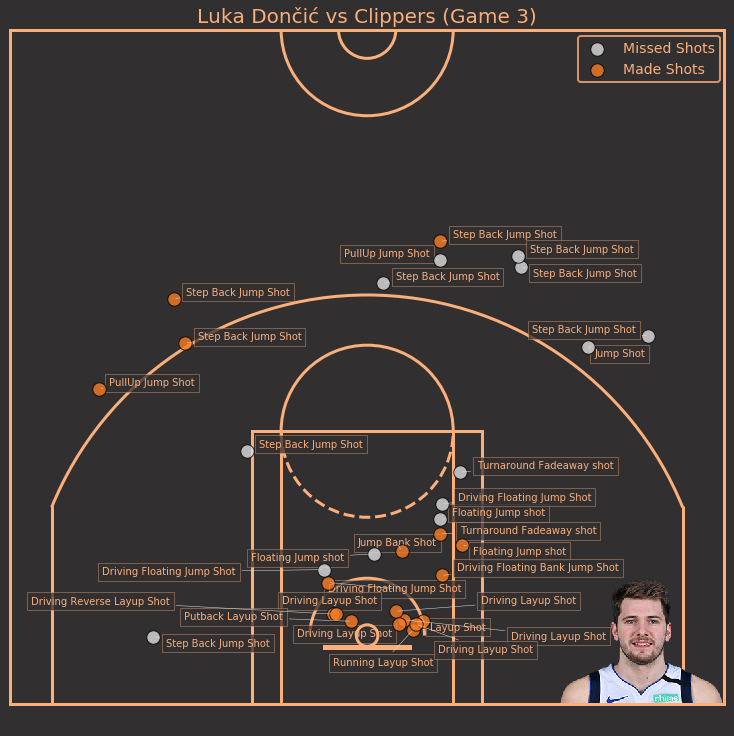

In [66]:
plot_raw_shotchart(data_frame=doncic_shots, title="Luka Dončić vs Clippers (Game 3)", plot_types=True, plot_image=True)

### Jamal Murray


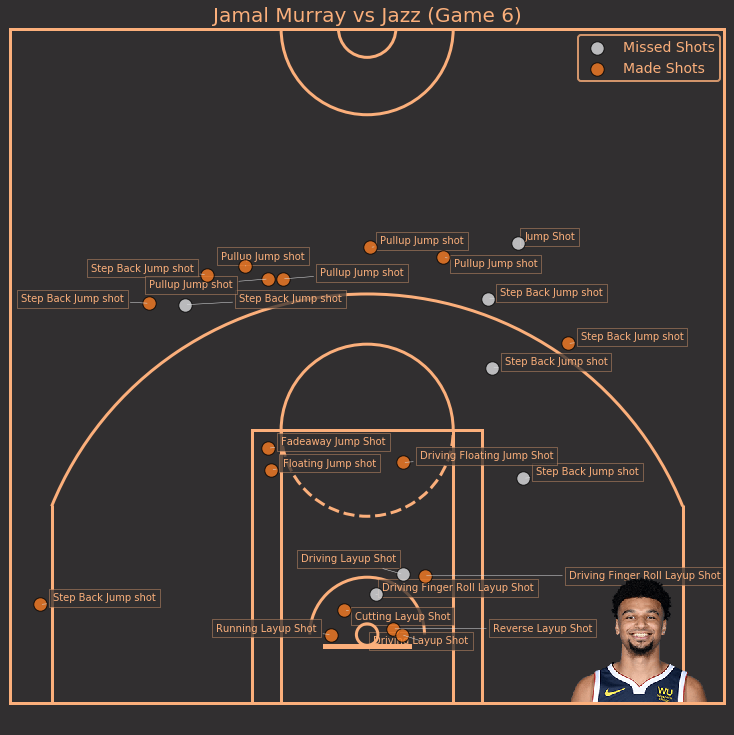

In [7]:
player_id = find_players_by_full_name("Jamal Murray")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Jamal Murray vs Jazz (Game 6)", plot_types=True, plot_image=True)

### Jimmy Butler

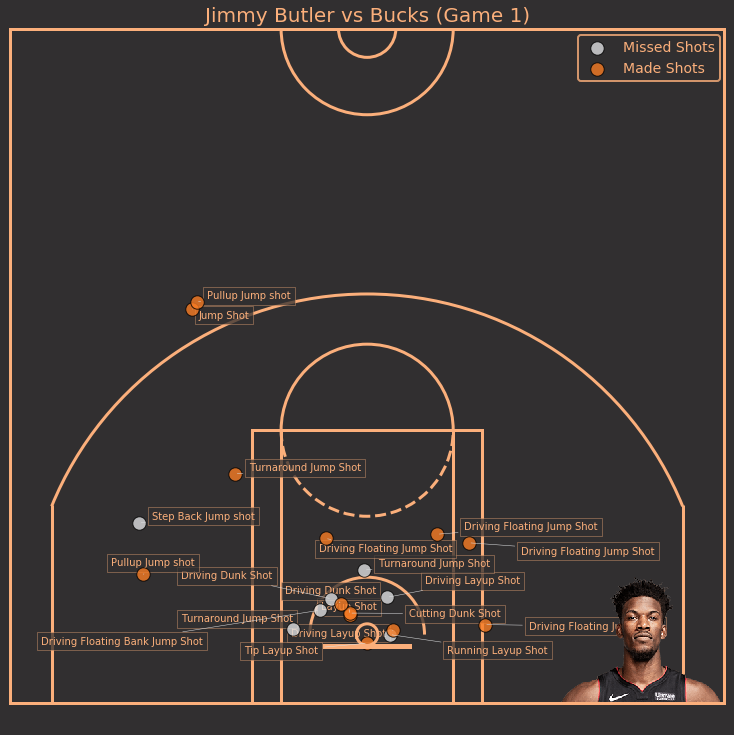

In [5]:
player_id = find_players_by_full_name("Jimmy Butler")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Jimmy Butler vs Bucks (Game 1)", plot_types=True, plot_image=True)

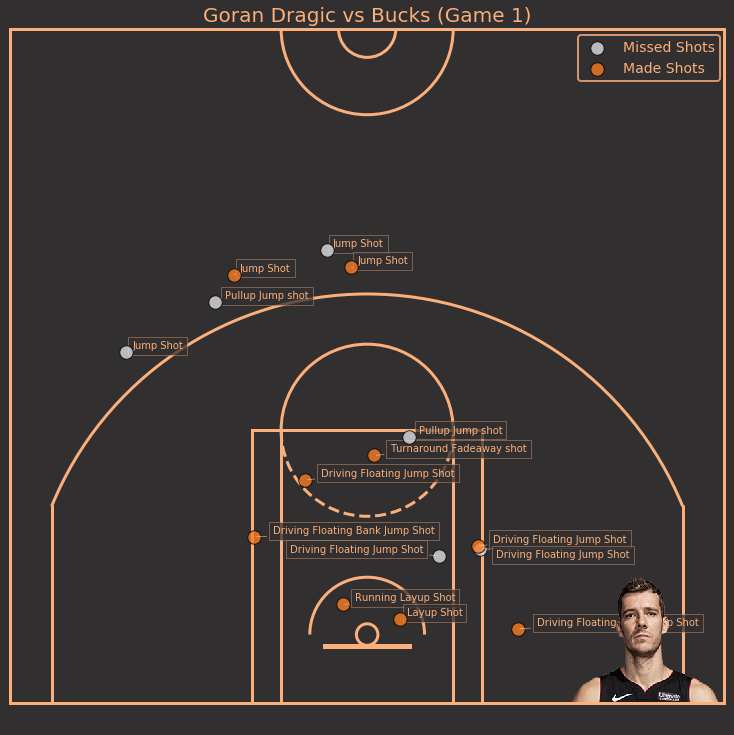

In [7]:
player_id = find_players_by_full_name("Goran Dragic")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Goran Dragic vs Bucks (Game 1)", plot_types=True, plot_image=True)

## Kyle Lowry

In [6]:
player_df.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

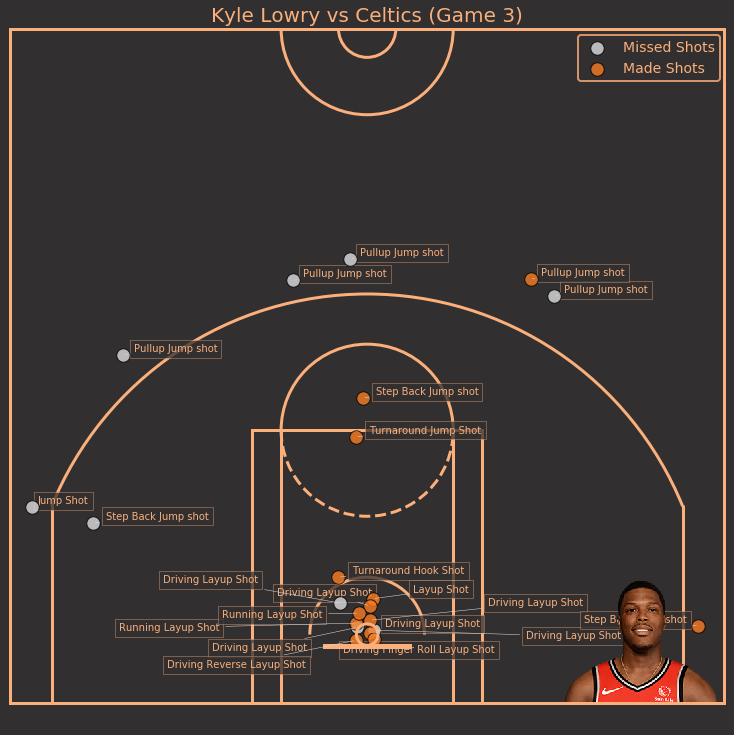

In [7]:
player_id = find_players_by_full_name("Kyle Lowry")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Kyle Lowry vs Celtics (Game 3)", plot_types=True, plot_image=True)

## James Harden

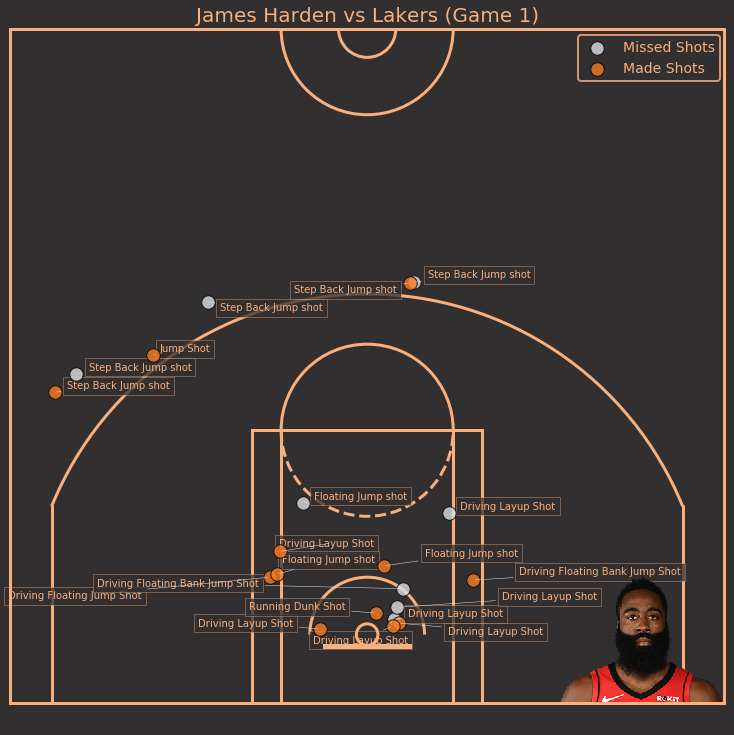

In [5]:
player_id = find_players_by_full_name("James Harden")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="James Harden vs Lakers (Game 1)", plot_types=True, plot_image=True)

### Anthony Davis

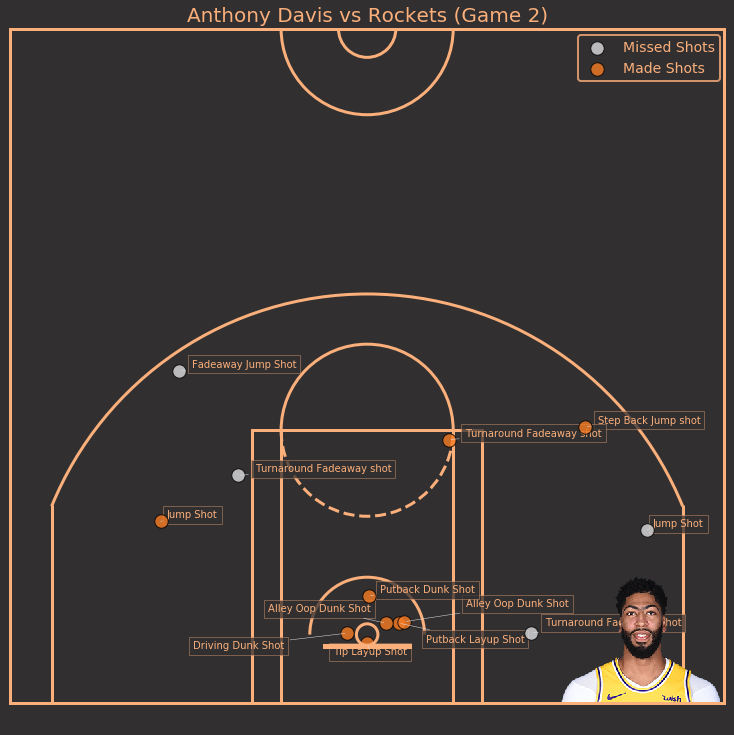

In [5]:
player_id = find_players_by_full_name("Anthony Davis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Anthony Davis vs Rockets (Game 2)", plot_types=True, plot_image=True)

### LeBron James


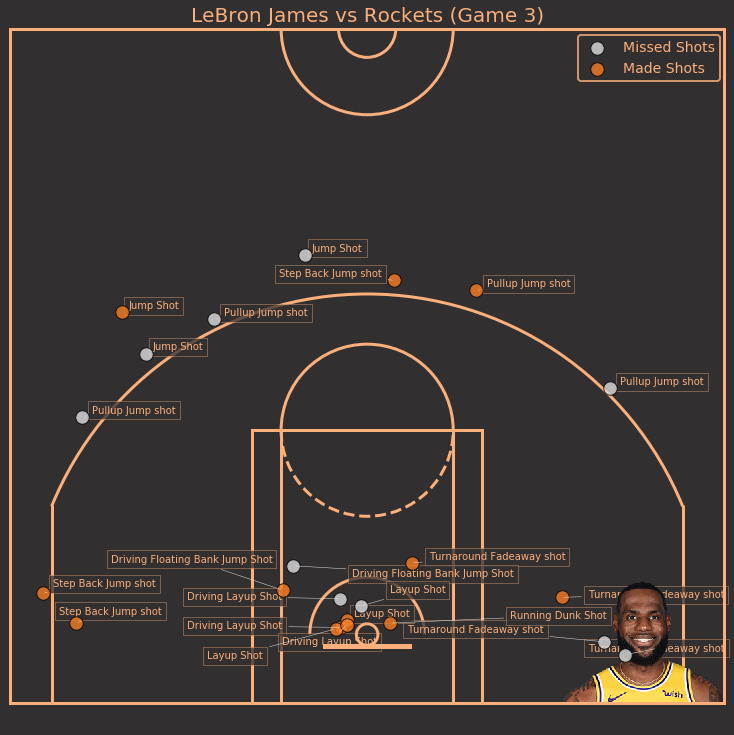

In [6]:
player_id = find_players_by_full_name("LeBron James")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="LeBron James vs Rockets (Game 3)", plot_types=True, plot_image=True)

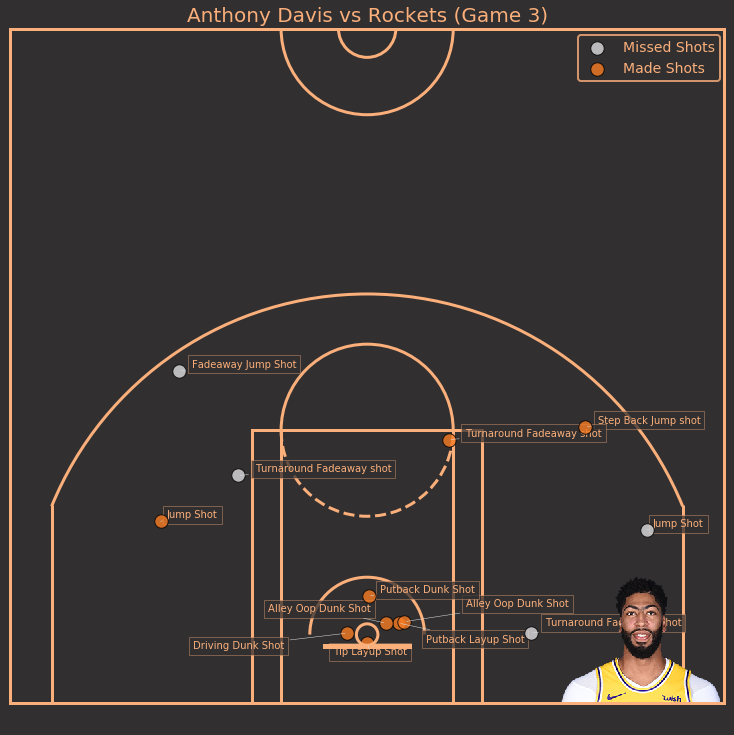

In [10]:
player_id = find_players_by_full_name("Anthony Davis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Anthony Davis vs Rockets (Game 3)", plot_types=True, plot_image=True)

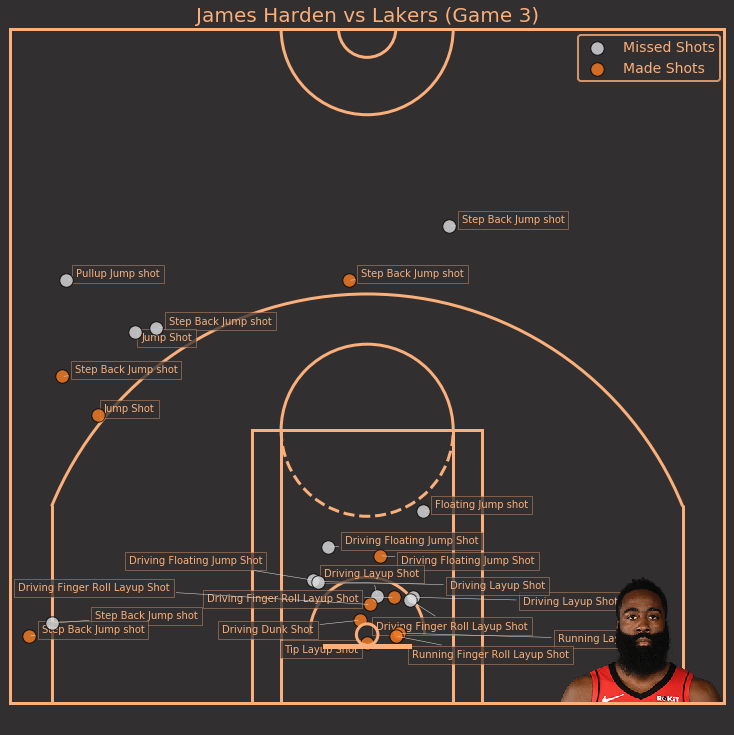

In [7]:
player_id = find_players_by_full_name("James Harden")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="James Harden vs Lakers (Game 3)", plot_types=True, plot_image=True)

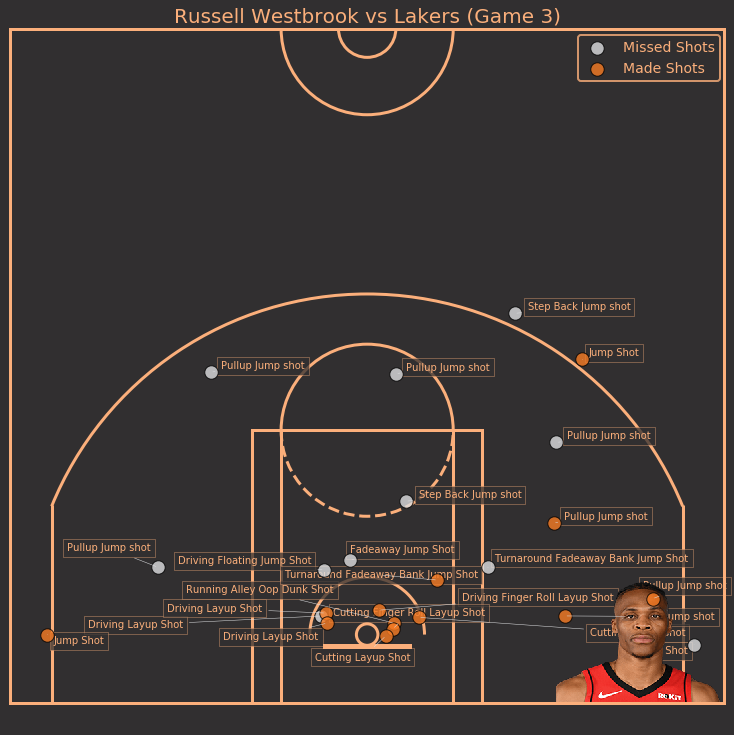

In [9]:
player_id = find_players_by_full_name("Russell Westbrook")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]


plot_raw_shotchart(data_frame=player_df, title="Russell Westbrook vs Lakers (Game 3)", plot_types=True, plot_image=True)

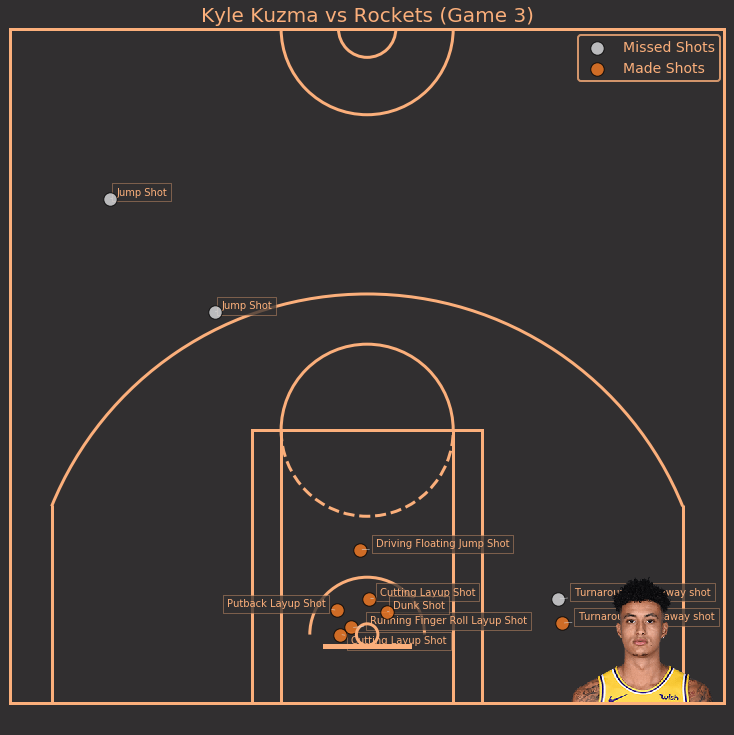

In [11]:
player_id = find_players_by_full_name("Kyle Kuzma")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Kyle Kuzma vs Rockets (Game 3)", plot_types=True, plot_image=True)

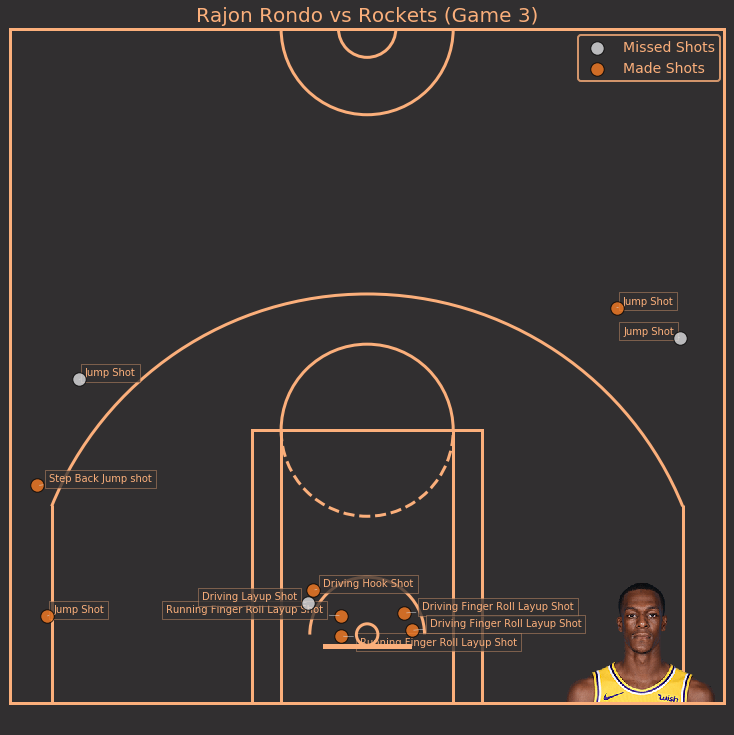

In [13]:
player_id = find_players_by_full_name("Rajon Rondo")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Rajon Rondo vs Rockets (Game 3)", plot_types=True, plot_image=True)

### Kyle Lowry

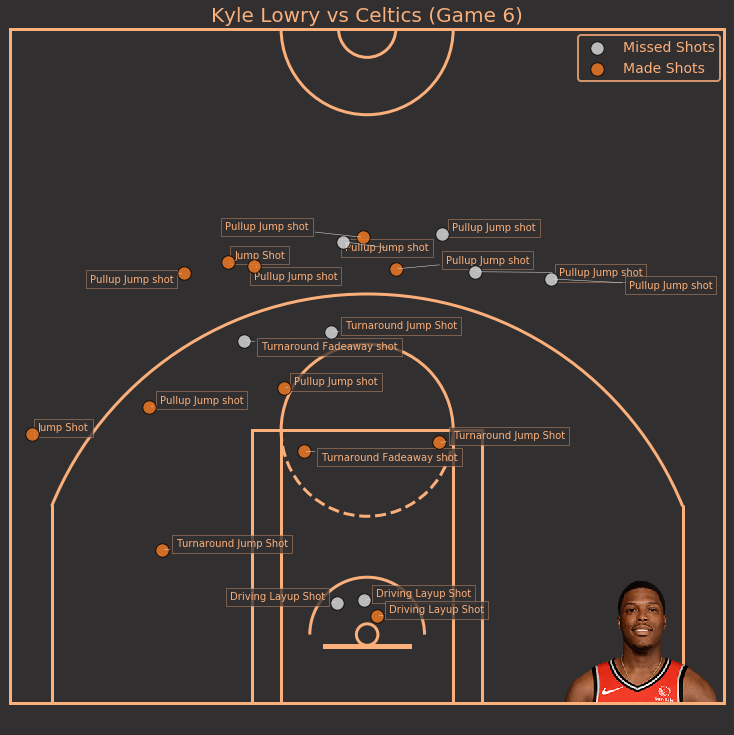

In [5]:
player_id = find_players_by_full_name("Kyle Lowry")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Kyle Lowry vs Celtics (Game 6)", plot_types=True, plot_image=True)

### King James

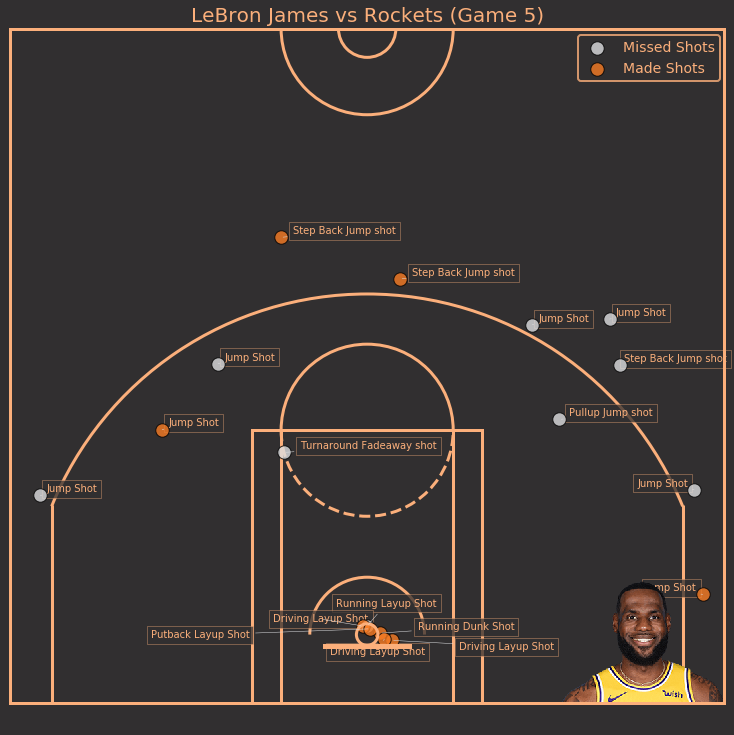

In [5]:
player_id = find_players_by_full_name("LeBron James")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="LeBron James vs Rockets (Game 5)", plot_types=True, plot_image=True)

### Nikola Jokic

In [9]:
player_id = find_players_by_full_name("Nikola Jokic")[0]['id']

In [ ]:
1610612743

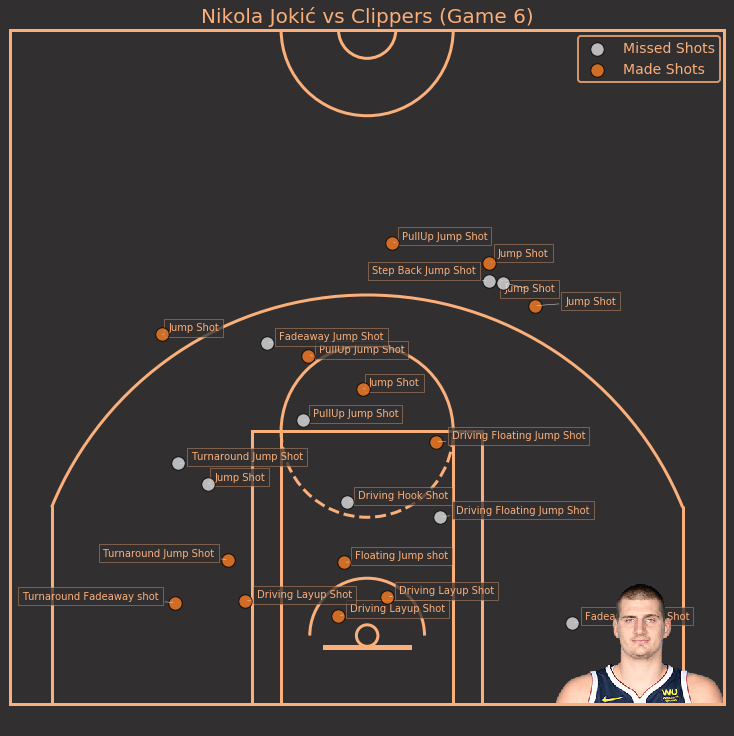

In [15]:
resp = requests.get("https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2019/scores/pbp/0041900236_full_pbp.json")

data = resp.json()

player_events = []
for quarter_dict in data['g']['pd']:
    for item in quarter_dict['pla']:
        if item['pid'] == player_id and (item['etype'] == 1 or item['etype'] == 2):
            player_events.append(item)

player_shots = pd.DataFrame.from_dict(doncic_events)

player_shots.loc[:, "LOC_X"] = -doncic_shots.locX
player_shots.loc[:, "LOC_Y"] = doncic_shots.locY

player_shots.loc[:, "SHOT_MADE_FLAG"] = doncic_shots.etype == 1

player_shots.loc[:, "ACTION_TYPE"] = [item.split("Jokic")[1].split(":")[0].strip() for item in player_shots.de]

for index in range(len(player_shots)):
    item = player_shots.iloc[index]
    if item.mtype == 1:
        player_shots.loc[index, 'ACTION_TYPE'] = "Jump Shot"
    elif item.mtype == 79:
        player_shots.loc[index, 'ACTION_TYPE'] = "PullUp Jump Shot"
    elif item.mtype == 80:
        player_shots.loc[index, 'ACTION_TYPE'] = "Step Back Jump Shot"
    
player_shots.loc[:, 'TEAM_ID'] = 1610612743
player_shots.loc[:, 'PLAYER_ID'] = player_id
plot_raw_shotchart(data_frame=player_shots, title="Nikola Jokić vs Clippers (Game 6)", plot_types=True, plot_image=True)

### Jamal Murray


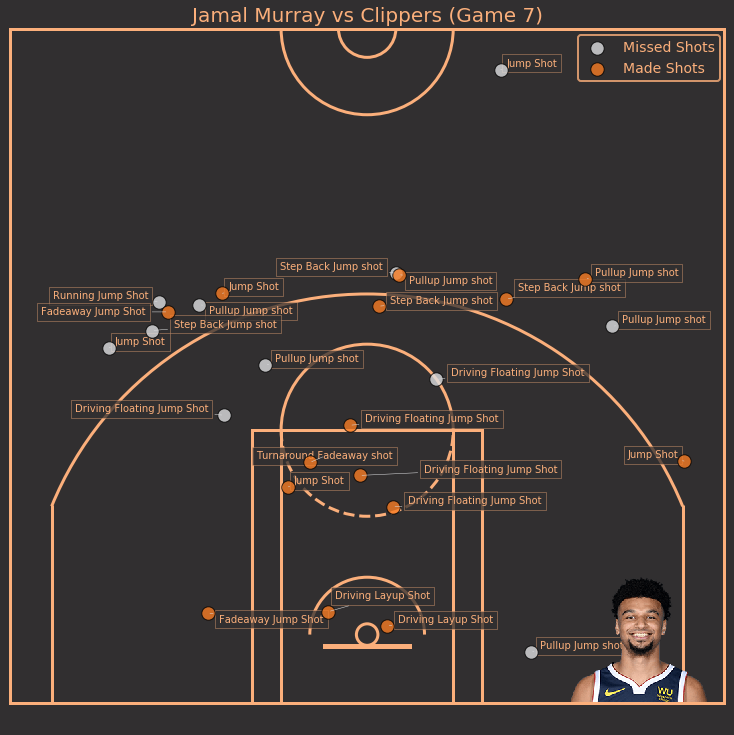

In [5]:
player_id = find_players_by_full_name("Jamal Murray")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Jamal Murray vs Clippers (Game 7)", plot_types=True, plot_image=True)

### Anthony Davis

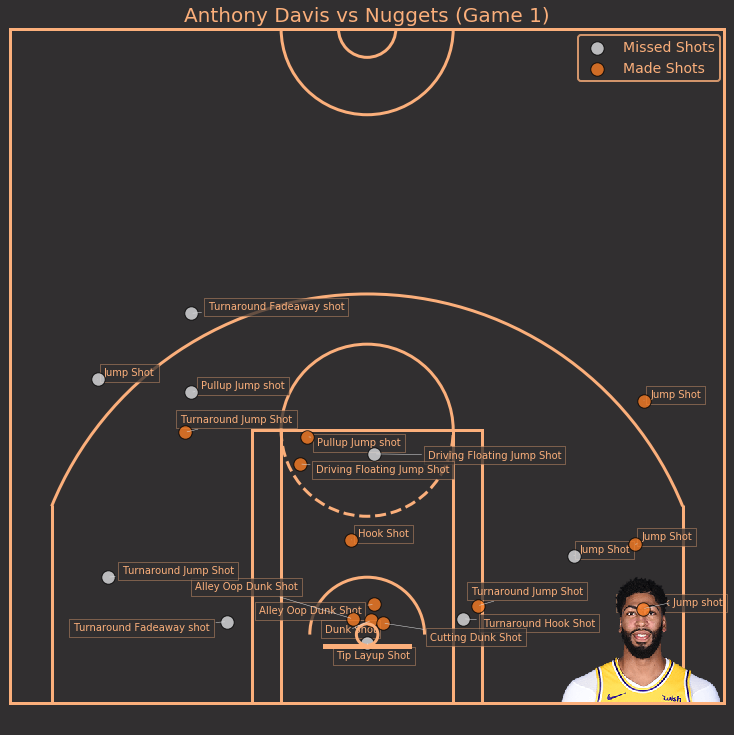

In [5]:
player_id = find_players_by_full_name("Anthony Davis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Anthony Davis vs Nuggets (Game 1)", plot_types=True, plot_image=True)

### Jaylen Brown


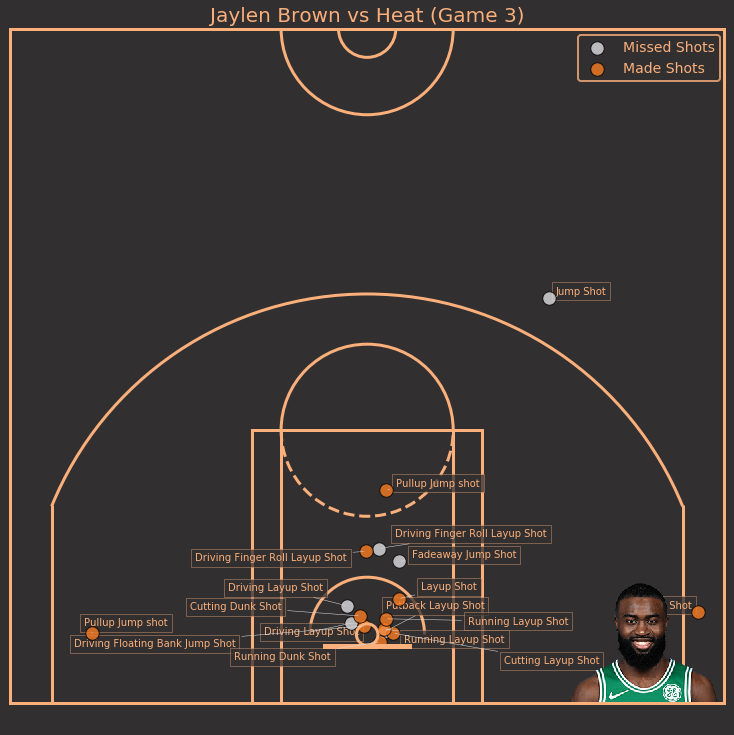

In [5]:
player_id = find_players_by_full_name("Jaylen Brown")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X
player_df = player_df.loc[player_df.SHOT_DISTANCE < 45]
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]



plot_raw_shotchart(data_frame=player_df, title="Jaylen Brown vs Heat (Game 3)", plot_types=True, plot_image=True)

### Anthony Davis